## Assignment 2: Neural Machine Translation

In this assignment, we will implement an encoder-decoder neural network for the task of machine translation.

![img](https://lena-voita.github.io/resources/lectures/seq2seq/general/enc_dec_simple_rnn-min.png)

We'll translate short image descriptions (without using the images themselves) from English to German. 
This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

### ❗  Contributions

**Please add a brief 1-2 sentence statement explaining the contributions of each group member (only refer to group members by UUNs):**


*< your contributions >*

## Setup

In [1]:
# install dependencies
!pip3 install torch pandas nltk matplotlib
!pip3 install subword-nmt &> log
!wget https://gist.githubusercontent.com/saparina/45e4e8af5cb6b57c786ca246e1c75530/raw/b7d06c8a570b68ef22c9fc2f627bbb8a54f4cf27/vocab.py

--2025-03-01 16:10:29--  https://gist.githubusercontent.com/saparina/45e4e8af5cb6b57c786ca246e1c75530/raw/b7d06c8a570b68ef22c9fc2f627bbb8a54f4cf27/vocab.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2878 (2.8K) [text/plain]
Saving to: ‘vocab.py.6’

vocab.py.6          100%[===================>]   2.81K  --.-KB/s    in 0s      

2025-03-01 16:10:29 (54.3 MB/s) - ‘vocab.py.6’ saved [2878/2878]



In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
source_lang = "en"
target_lang = "de"
splits = ['train', 'val', 'test']

data = {}
for split in splits:
    file_name = f"{split}.jsonl"
    df = pd.read_json(f"hf://datasets/bentrevett/multi30k/{file_name}", lines=True)
    data[split] = df

for split, df in data.items():
    df['de'].to_csv(f"{split}.de", index=False, header=False, mode='w')
    df['en'].to_csv(f"{split}.en", index=False, header=False, mode='w')

## 1. Data Preprocessing (5 points)

Before we get to the architecture, it is important to preprocess the data. For this assignment, the preprocessing has already been done for you. 

Here's the process:
1. The data is tokenized with [WordPunctTokenizer](https://www.nltk.org/api/nltk.tokenize.regexp.html#nltk.tokenize.regexp.WordPunctTokenizer)  which splits text based on word boundaries and punctuation.

2. Then we apply [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt). The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [6]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
for lang in [source_lang, target_lang]:
    for split in splits:
        with open(split + '.tok.' + lang, 'w') as f_src:
            for line in open(split + '.' + lang):
                f_src.write(tokenize(line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in [source_lang, target_lang]:
    learn_bpe(open('./train.tok.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    for split in splits:
        with open(split + '.bpe.' + lang, 'w') as f_out:
            for line in open(split + '.tok.' + lang):
                f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:07<00:00, 1116.46it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're will use them when we feed training data into model or convert output matrices into words.

In [7]:
train_inp = np.array(open('train.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
train_out = np.array(open('train.bpe.' + target_lang, encoding='utf-8').read().split('\n'))

val_inp   = np.array(open('val.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
val_out   = np.array(open('val.bpe.' + target_lang, encoding='utf-8').read().split('\n'))

test_inp = np.array(open('test.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
test_out = np.array(open('test.bpe.' + target_lang, encoding='utf-8').read().split('\n'))

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: " two young , white males are outside near many bushes ."
out: zwei junge weiße männer sind im freien in der nähe viel@@ er büsche .

inp: several men in hard hats are operating a giant pulley system .
out: mehrere männer mit schutzhelmen bedienen ein an@@ tri@@ eb@@ s@@ rad@@ system .

inp: a little girl climbing into a wooden playhouse .
out: ein kleines mädchen klettert in ein spiel@@ haus aus holz .



In [8]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

print("Source vocab size", len(inp_voc))
print("Target vocab size", len(out_voc))

Source vocab size 7202
Target vocab size 7679


In [9]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['men play baseball .', 'a child in a swing .', 'a man playing cricket', 'a car is in the water', 'a man climbs a rock .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 3659, 4416,  544,   22,    1,    1,    1],
        [   0,   65, 1166, 2969,   65, 6002,   22,    1],
        [   0,   65, 3568, 4424, 1513,    1,    1,    1],
        [   0,   65, 1010, 3065, 2969, 6186, 6902,    1],
        [   0,   65, 3568, 1255,   65, 4901,   22,    1]])

back to words
['men play baseball .', 'a child in a swing .', 'a man playing cricket', 'a car is in the water', 'a man climbs a rock .']


Draw source and translation length distributions to estimate the scope of the task.

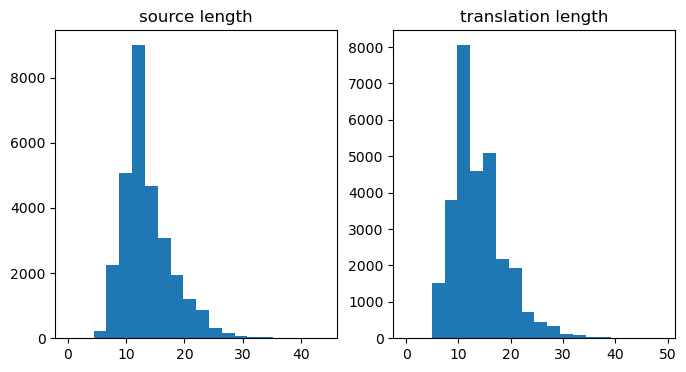

In [10]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### ❓ Question (5 points)

What tokens correspond to indices 0 and 1 in vocabulary? What roles do they play? Is it possible to train a model without them, and if so, how?

*Index 0 corresponds to \<bos\>, which is the beginning of sequence, and 1 corresponds to \<eos\>, which is the end of sequence. \<bos\> marks the start of a sequence, and \<eos\> defines when to stop generation during inference. It is possible to train a model without them, e.g. by forcing fixed-length outputs, but this may be risky for variable-length sequences.*

## 2. Basic Encoder-Decoder Model (15 points)

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. You need to implement ```decode_step``` (5 points).

In [11]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        # compute embeddings
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        # sequentially applying a GRU cell to each input 
        # (this logic is hidden in the GRU implementation)
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: enc0 works on a batch level, so we will need to process padding!
        # last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        # create an initial hidden vector for the decoder
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        # <get embedding of previous tokens>
        previous_embedding = self.emb_out(prev_tokens) 
        # <apply decoder rnn cell>
        new_dec_state = self.dec0(previous_embedding, prev_state[0])
        # <get logits>
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step, use for training"""
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            # note: we use the reference labels here (out_tokens)
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version), use for inference """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            # note: we use the predicted tokens
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [12]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list), type(h1)
assert len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [13]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
afri@@ fußgängerbrücke teenagerin musku@@ football@@ pfeil orche@@ stie@@ y lackiert lackiert pre@@ afroamerikan@@ dribbelt stellt tzt winterjacke sportlerin ron stift aufhat trainieren etwas schrif@@ gür@@
afri@@ tte richter richter repariert vorbei ” suchen haltung verkehrt ara@@ trüben alls spielend akkordeon@@ packen steu@@ noti@@ lö@@ pustet übung neben@@ coca ehnt promenade
afri@@ wildwasser@@ 8@@ schleife rennt schnau@@ telef@@ telef@@ gegend hier ganzen oberteilen felsbrocken tro@@ handschuhe lächelndes 4@@ hemd@@ anzüge babyschaukel unterhaltung kreide koch@@ tanzfläche skolben


### Training loss (5 points)

Our training objective is:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [14]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    # <get outputs from the model>
    outputs = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    # <compute log-probabilities>
    log_probs = torch.log_softmax(outputs, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    # <get log-probabilities of correct outputs, you can use targets_1hot>
    correct_log_probs = (log_probs * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.

    # average cross-entropy over tokens where mask == True
    # <apply mask>
    loss_elems = -(correct_log_probs * mask)
    # <get average loss>
    loss = loss_elems.sum() / mask.sum()
    
    return loss

In [15]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.6, rtol=0.01, atol=0.01), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

print("Test passed!")

Loss: tensor(7.6071, grad_fn=<DivBackward0>)
Test passed!


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

In [16]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [17]:
compute_bleu(model, val_inp, val_out)

0.004044872108229374

### Training loop (2+3 points)

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [18]:
from IPython.display import clear_output
from tqdm import tqdm, trange

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [19]:
print("Model size", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6, "M")

Model size 2.108479 M


Implement training loop (2 points):

In [20]:
def train(model, opt, batch_size, num_steps=20000, save_path="best_basemodel.pth"):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    best_bleu = 0.0
    for _ in trange(num_steps):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

        # <compute loss>
        loss_t = compute_loss(model, batch_inp, batch_out)
        # <do optimizer step>
        opt.zero_grad()
        loss_t.backward()
        opt.step()

        metrics['train_loss'].append((step, loss_t.item()))

        if step % 100 == 0:
            dev_bleu = compute_bleu(model, val_inp, val_out)
            metrics['dev_bleu'].append((step, dev_bleu))

            if dev_bleu > best_bleu:
                best_bleu = dev_bleu
                torch.save(model.state_dict(), save_path)

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    return metrics

Train your model (3 points):

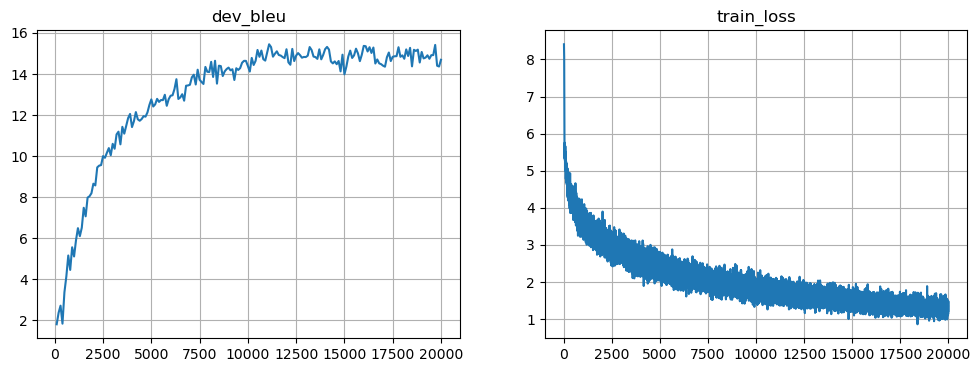

Mean loss=1.322


100%|██████████| 20000/20000 [1:43:55<00:00,  3.21it/s]


In [21]:
metrics = train(model, opt, batch_size)
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [22]:
bleu_scores = np.mean(metrics['dev_bleu'][-10:], axis=0)[1]
assert bleu_scores > 13, f"BLEU score should be > 13 on average, you got {bleu_scores}"

In [23]:
model.load_state_dict(torch.load("best_basemodel.pth", weights_only=True))
model.to(device)

final_bleu_score = compute_bleu(model, test_inp, test_out)
f"BLEU score on the test set: {final_bleu_score:.3}"

'BLEU score on the test set: 14.2'

## 3. Encoder-Decoder Model with Attention (15 points)

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (6 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute scores with a 2-layer neural network:
$$s_t = linear_{out}(tanh(linear_{enc}(h^e_t) + linear_{dec}(h^d)))$$
* Get probabilities from scores:
$$ p_t = {{e ^ {s_t}} \over { \sum_\tau e^{s_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__ (attention context vector):
$$ c = \sum_t p_t \cdot h^e_t $$

In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        # create trainable paramteres
        self.linear_enc = nn.Parameter(torch.zeros(self.enc_size, self.hid_size), requires_grad=True)
        self.linear_dec = nn.Parameter(torch.zeros(self.dec_size, self.hid_size), requires_grad=True) # you will need a couple of these
        self.linear_out = nn.Parameter(torch.zeros(self.hid_size, 1), requires_grad=True)

        torch.nn.init.xavier_uniform_(self.linear_enc.data)
        torch.nn.init.xavier_uniform_(self.linear_dec.data)
        torch.nn.init.xavier_uniform_(self.linear_out.data)


    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        # Compute scores
        # <compute scores: use linear_enc, linear_dec, linear_out and activ>
        scores = self.activ(torch.matmul(enc, self.linear_enc) + torch.matmul(dec, self.linear_dec).unsqueeze(1))
        scores = torch.matmul(scores, self.linear_out).squeeze(-1)

        # Apply mask - if mask is 0, scores should be -inf or -1e9
        # You may need torch.where
        # <apply inp_mask>
        scores = torch.where(inp_mask, scores, -1e9)

        # Compute attention probabilities (softmax)
        # <get attention probabilities from scores>
        probs = torch.softmax(scores, dim=-1)

        # Compute attention response using enc and probs
        # <get attention response using probabilities and encoder states>
        attn = torch.bmm(probs.unsqueeze(1), enc).squeeze(1)

        return attn, probs

In [25]:
# debugging
batch_size = 32
ninp = 7
enc_size = 64
dec_size = 128
layer = AttentionLayer("", enc_size, dec_size, 72)
attn, probs = layer(torch.rand(batch_size, ninp, enc_size), torch.rand(batch_size, dec_size), torch.rand(batch_size, ninp) > .5)
assert attn.shape == (batch_size, enc_size), attn.shape
assert probs.shape == (batch_size, ninp), probs.shape # if you have redundant dimensions of size 1, you might find torch.squeeze useful

### Seq2seq model with attention (6 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://lena-voita.github.io/resources/lectures/seq2seq/attention/bahdanau_model-min.png)

- On every step, use __previous__ decoder state to obtain attention response. 
- Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Any tensor added into the list of `encode` outputs list will be available for use during each `decode` step. You should include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention response and attention probabilities (to visualize)

In [26]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. Inherit all functions and params of BasicModel """
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        super().__init__(inp_voc, out_voc, emb_size=emb_size, hid_size=hid_size)
        self.attention = AttentionLayer(name, hid_size, hid_size, attn_size)
        self.dec0 = nn.GRUCell(emb_size + attn_size, hid_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        # <get source embedding>
        inp_emb = self.emb_inp(inp)

        # <apply encoder rnn cell to get encoder states>
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.inp_voc.compute_mask(inp)

        # <get attention response and probabilities>
        first_attn_response, first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_response, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        prev_gru0_state, enc_seq, inp_mask, prev_attn_response, prev_attn_probas = prev_state

        # <get embeddings of previous tokens>
        prev_tokens_emb =  self.emb_out(prev_tokens)
        # <concatenate embeddings and prev attention response>
        concat_inp = torch.cat([prev_tokens_emb, prev_attn_response], dim=1)
        # <apply decoder rnn cell to get decoder states>
        new_dec_state = self.dec0(concat_inp, prev_gru0_state)
        # <get logits>
        output_logits = self.logits(new_dec_state)

        # <get attention response and probabilities>
        attn_response, attn_probas = self.attention(enc_seq, new_dec_state, inp_mask)

        return [new_dec_state, enc_seq, inp_mask, attn_response, attn_probas], output_logits


### Training attentive model (3 points)

Please reuse the infrastructure you've built for the basic model.

In [27]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel("model", inp_voc, out_voc, hid_size=128, attn_size=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

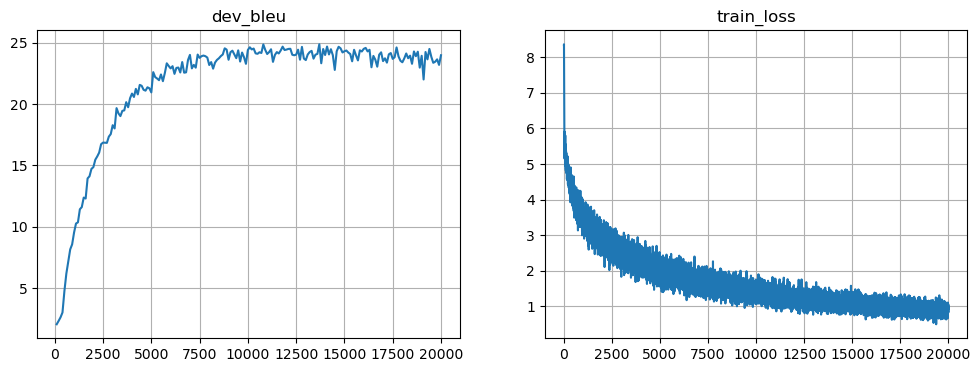

Mean loss=0.917


100%|██████████| 20000/20000 [2:24:56<00:00,  2.30it/s]


In [28]:
metrics = train(model, opt, batch_size, save_path="best_attentivemodel.pth")

In [29]:
model.load_state_dict(torch.load("best_attentivemodel.pth", weights_only=True))
model.to(device)

final_bleu_score = compute_bleu(model, test_inp, test_out)
f"BLEU score on the test set: {final_bleu_score:.3}"

'BLEU score on the test set: 24.1'

### ❓ Question

Compare the BLEU scores of the attentive model and the basic model you trained in the previous section. Which one performs better, and why?

*The attentive model (BLEU 24.1) outperforms the basic model (BLEU 14.2) significantly. This is because the attention mechanism dynamically aligns source and target tokens, enabling better context capture and handling of long-range dependencies, which the basic model’s fixed-context approach struggles with.*

## 4. Analyzing NMT (10 points)

### Translation Analysis (4 points)

Let's explore how the model we trained translates: 


In [30]:
for inp_line in test_inp[:5]:
    # <translate the sentences>
    trans_line = model.translate_lines([inp_line])
    print(inp_line)
    # extracting the first element
    print(trans_line[0])
    print()

a man in an orange hat starring at something .
['ein mann mit einem orangefarbenen hut starrt etwas auf etwas .']

a boston terrier is running on lush green grass in front of a white fence .
['ein fan macht auf einer grünen wiese vor einem weißen zaun .']

a girl in karate uniform breaking a stick with a front kick .
['ein mädchen in karateanzügen macht einen stock mit einem stock .']

" five people wearing winter jackets and helmets stand in the snow , with snow@@ mobil@@ es in the background ."
['fünf personen in wintermänteln - kostümen und helmen stehen im schnee .']

people are fixing the roof of a house .
['leute fahren auf einem dach im freien .']



### ❓ Questions

1. Analyze the types of errors your model makes.  You may use any external translator (e.g., Google Translate) to translate your German predictions back to English to better understand their meaning.

*The model sometimes changes key actions, e.g. "breaking a stick" becomes "makes a stick", and "fixing the roof" becomes "riding on a roof". It also confuses objects, like turning "boston terrier" into "fan", or missing "snowmobiles". These errors indicate that the model struggles with capturing nuanced meanings and fine-grained details in the input.*

2. What can help improve these translations?

*Improving translations could involve training on a larger and more diverse dataset, and adopting more advanced architectures like Transformers. Moreover, refining the tokenization and decoding strategies may help capture finer details in the source sentences.*

### Visualizing model attention (6 points)

You can validate your model by visualizing its attention weights. We provided you with a function that draws attention maps.

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def draw_attention(inp_line, translation, probs):
    """ Visualize attention weights with a black background and white squares """
    # Tokenize input and translation
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.set_facecolor("black")
    cax = ax.matshow(probs[::-1], cmap='gray')
    
    color_bar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(inp_tokens)))
    ax.set_xticklabels(inp_tokens, rotation=45, ha='left', rotation_mode='anchor')

    ax.set_yticks(np.arange(len(trans_tokens)))
    ax.set_yticklabels(trans_tokens[::-1])
    
    
    ax.tick_params(axis='both', which='both', length=0)  
    ax.spines[:].set_visible(False) 

    plt.show()

In [32]:
trans, states = model.translate_lines(test_inp[:5])

# select attention probs from model state
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)

# <get attention probabilities>
attention_probs = np.stack([state[-1].detach().numpy() for state in states], axis=1)


In [33]:
# Check for all examples and all translation steps
assert np.allclose(attention_probs.sum(axis=2), 1.0, atol=1e-4), "Attention probabilities do not sum to 1!"

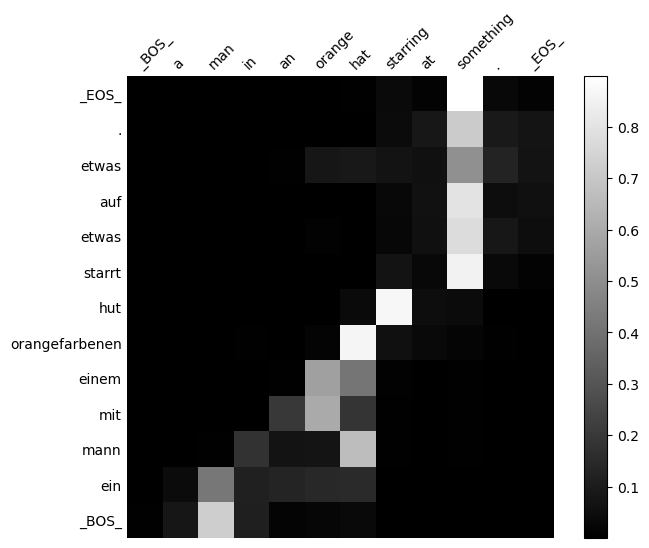

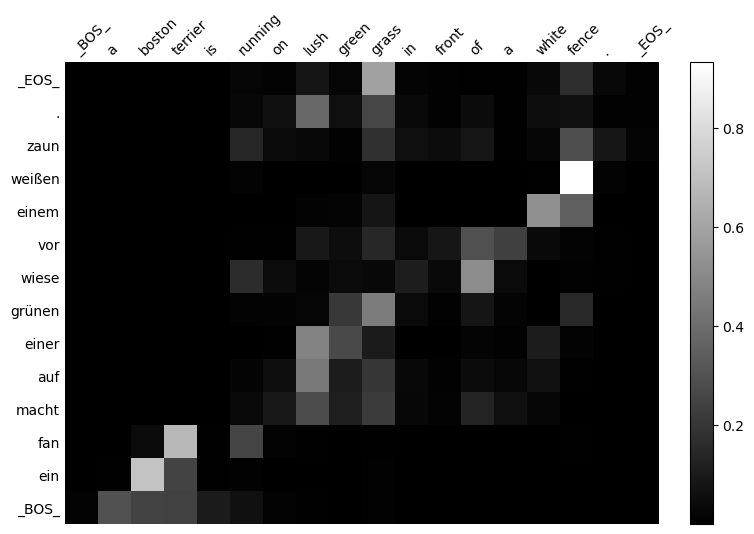

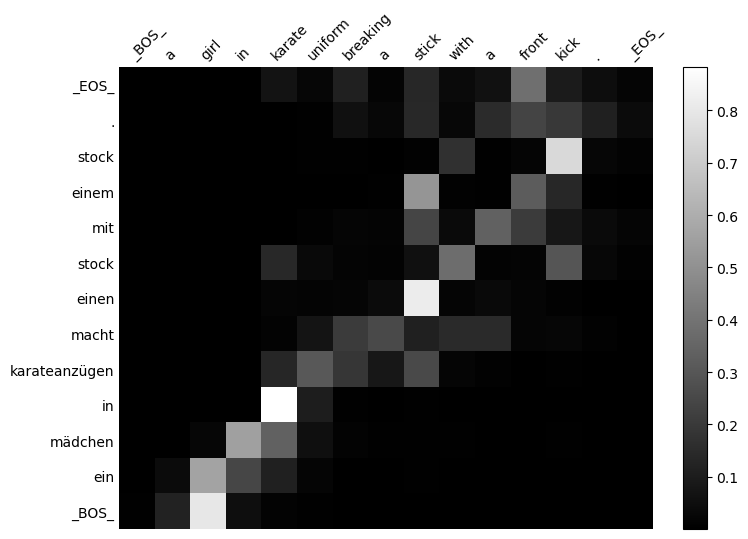

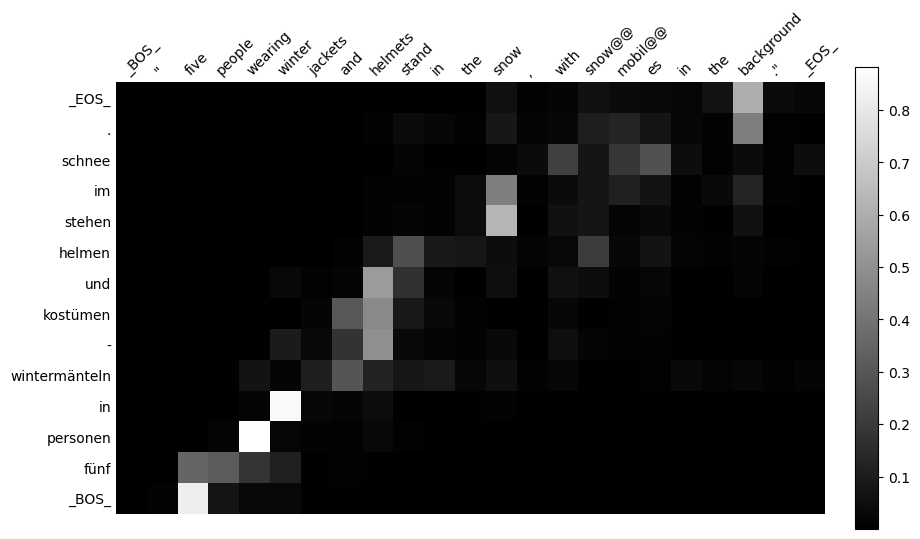

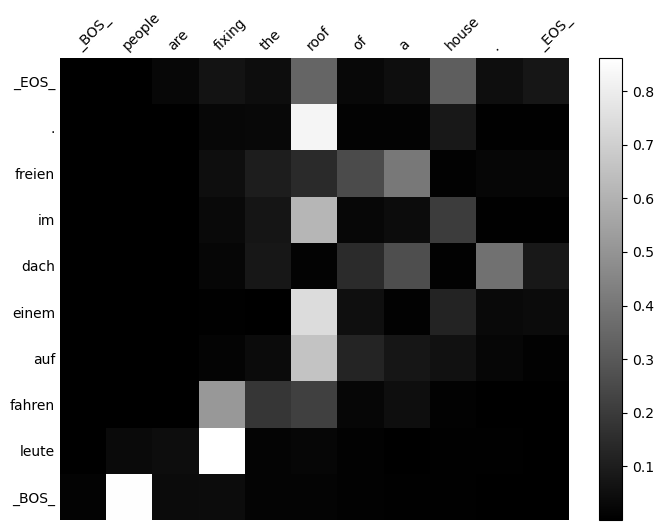

In [34]:
for i in range(5):
    draw_attention(test_inp[i], trans[i], attention_probs[i])
# Does it look fine already? don't forget to save images!

### ❓ Question

Interpret how attention works:

*Across all five test sentences, the attention shows strong alignment in the first half of sentences, with a clear diagonal pattern, especially in shorter sentences. However, as sentences grow longer, attention weights become more scattered, particularly towards the end, leading to mistranslation issues. Some words receive multiple focus points, indicating ambiguity in translation, for instance with complex noun phrases and word reordering, as seen in phrases like "lush green grass". Overall, while the model performs well in simpler cases, it struggles to maintain precise alignment and context in longer and more complex sentences.*